This notebook contains:
    1. Data, Train, Test, Random Forest Model
    2. Functions
        a. Line of scrimmage calculator
        b. Plot the field
        c. Plot a play with rusher direction
        d. Plot player movement as multiple plots
        e. Save multiple pngs as GIF
    3. User input to plot a play and give play info


References:
1. Field Plot https://www.kaggle.com/robikscube/nfl-big-data-bowl-plotting-player-position
2. Play Plot https://www.kaggle.com/miliman13/nfl-plotting-play-situation

In [444]:
import pickle
import pandas as pd
import numpy as np
import math
# plots
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [12]:
# load data and model
data = pd.read_pickle('data.pkl')
# trained model
rf = pd.read_pickle('rf_model.sav')
trainX = pd.read_pickle('trainX.pkl')
testX = pd.read_pickle('testX.pkl')

In [13]:
# label bins need to be in integers for neural network to get dummy variables for the label array
bin_int = {'-10 or less':0,
           '-9 to -4':1,
           '-3 to -1':2,
           '0 to 3':3,
           '4 to 7':4,
           '8 to 10':5,
           '11 to 15':6,
           '16 to 25':7,
           '26+':8}
data['yards_bin_int'] = data['yards_binned'].map(bin_int)
bin_yard_names = list(bin_int.keys())
# get labels
bin_trainy = data.loc[data['season'] != 2019]['yards_bin_int']
bin_testY = data.loc[data['season'] == 2019]['yards_bin_int']

In [429]:
def get_pred():

Index(['rushy', 'gameclock', 'rushx', 'min_distancetorusher',
       'avgyardspergame', 'yardfromowngoal', 'yardline', 'week',
       'homescorebeforeplay', 'visitorscorebeforeplay',
       'total_playersblocked_revised', 'distance', 'x_standard', 'x_handoff',
       'quarter'],
      dtype='object')

In [29]:
# get predictions
y_pred = rf.predict(testX)
# create a df
preds = pd.DataFrame(zip(bin_testY, y_pred), columns = ['true', 'pred'], index = testX.index)
cor_preds = preds.loc[preds['true'] == preds['pred']]
# add predictions to 
df = data.iloc[list(cor_preds.index)]
# get all variables for correct predictions
df['pred'] = cor_preds['pred']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Play Plotting Functions

### Line of Scrimmage

In [500]:
# define a line of scrimmage function
def line_of_scrimmage(playid):
    play_info = data.loc[data['playid'] == playid]
    pos_team = play_info['possessionteam']
    pos = play_info.loc[play_info['possessionteam'] == pos_team]
    if pos['possessionteam'].tolist()[0] != pos['fieldposition'].tolist()[0]:
        los = 110 - pos['yardline'].tolist()[0]
    else:
        los = pos['yardline'].tolist()[0] +10
    return los

### Plot Field for Plot Space

In [40]:
import matplotlib.patches as patches
# los = line of scrimmage
'''
function defines default parameters that can be turned on/off
returns rectangle that resembles the field
bottom left corner is (0,0)

parameters: 
    turn on/off 
        - line numbers 
        - endzones
        - highlighted los
        - fifty yard line as default los
    highlight_los_number = yard line of los
'''
def plot_field(linenumbers = True, # show numbers on the field
              endzones = True, # can turn endzones on/off
              highlight_los = False, # show line of scrimmage
              highlight_los_number = 50, # default line of scrimmage = 50
              highlighted_name = 'Line of Scrimmage',
              fifty_is_los = False, # use default line of scrimmage
              figsize = (12, 5.33)): # 1/10 scale of the 120 x 53.3
    # define the rectangle that is the field
    field = patches.Rectangle((0,0), 120, 53.3, linewidth = 0.1,
                             edgecolor = 'red',
                             facecolor = 'green',
                             zorder = 0) # zorder = 0 - plot this first
    fig, ax = plt.subplots(1, figsize = figsize)
    # add the patch to the axes
    ax.add_patch(field)
    # define the field markers
    # first list is the x-coord, second is the y-coord 
    # the map together to plot vertical lines
    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120], 
            [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
            color = 'white')    
    # check for line of scrimmage
    if fifty_is_los:
        plt.plot([60,60], [0, 53.3], color = 'gold')
        plt.text(62, 50, '<- Line of Scrimmage', color = 'gold')
    # color the endzones so they stand out, if set to True
    if endzones:
        endzone1 = patches.Rectangle((0,0), 10, 53.3, # left endzone
                                    linewidth = 0.1,
                                    edgecolor = 'red',
                                    facecolor = 'midnightblue', # color of endzone
                                    alpha = 0.8, # transparency
                                    zorder = 0)
        endzone2 = patches.Rectangle((110,0), 120, 53.3, # right endzone
                                    linewidth = 0.1,
                                    edgecolor = 'red',
                                    facecolor = 'midnightblue',
                                    alpha = 0.8,
                                    zorder = 0)
        # add the patches to the endzones
        ax.add_patch(endzone1)
        ax.add_patch(endzone2)
        # set plot limits for the field
        plt.xlim(0, 120)
        plt.ylim(-5, 58.3) # a little extra padding on top and bottom
        plt.axis('off')
        # line numbers = True
        if linenumbers:
            for x in range(20, 110, 10): # start at the goalline and end on the goalline
                number = x
                # start with 20,30... once we get to midfield count backward
                if x > 50:
                    number = 120 - x
                # bottom numbers
                plt.text(x, 5, str(number - 10),
                        horizontalalignment = 'center',
                        fontsize = 12,
                        color = 'white')
                # top numbers
                plt.text(x - 0.95, 53.3 - 5, str(number - 10), # numbers are kind of off
                        horizontalalignment = 'center',
                        fontsize = 12,
                        color = 'white',
                        rotation = 180) # turn upside down to mimic a real field
    # set hash marks for middle of field and sidelines
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(0, 120)
    # print the hash marks on each yard line
    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color = 'white') #bottom sideline
        ax.plot([x, x], [53.0, 52.5], color = 'white') #top sideline
        ax.plot([x, x], [22.91, 23.57], color = 'white') # right hash - middle of field
        ax.plot([x, x], [29.73, 30.59], color = 'white') # left hash - middle of field
    # if highlight_los = True 
    if highlight_los:
        if highlight_los_number < 50:
            h1 = highlight_los_number + 10# account for the endzone
        else:
            h1 = highlight_los_number
        plt.plot([h1, h1], [0, 53.3], 
                 color = 'gold') # define from bottom to top
        plt.text(h1 + 2, 3.3, '<- {}'.format(highlighted_name), 
                 color = 'gold')
    
    return fig, ax

### Plot a Play

In [508]:
# function to plot a play - arrows are direction
'''
    Requires a play ID
    can turn on/off orientation and direction arrows
    can turn on/off end of play yard line
    default is on
    '''
def plot_play(playid, 
             show_end = False, # show the finish yard line of the play
             show_los = True, # show line of scrimmage of play
             show_orientation = False, # turn on/off orientation arrow (default = off)
             show_direction = True, # turn on/off direction arrow (default = on)
             show_yards = True, # show the yards gained
             show_play_info = True): # display team info - score, name
    # get the play info
    play_info = data.loc[data['playid'] == playid]
    # plot line of scrimmage
    if show_los:
        los = line_of_scrimmage(playid)
        fig, ax = plot_field(highlight_los = True,
                    highlight_los_number = los)
    else:
        fig, ax = plot_field()
    
    
    # possession team is on opponent's side of field
    if play_info['possessionteam'].tolist()[0] != play_info['fieldposition'].tolist()[0]:
        if play_info['playdirection'].tolist()[0] == 'left':
             play_info['x_standard'] = play_info['x_standard'] + 2*abs(50-play_info['yardline'])
       # else:
            # something else
    # possession team is on their side of field
    else:
        if play_info['playdirection'].tolist()[0] == 'left':
            play_info['x_standard'] = play_info['x_standard'] - 2*abs(50-play_info['yardline'])
            los = los + 10
    
    
    # scatter plot of players initial position
    '''
    # plot away team
    data.loc[(data['playid'] == playid)&(data['team'] == 'away')].plot(
        x = 'x_standard', 
        y = 'y_standard', 
        kind = 'scatter', 
        ax = ax, 
        color = 'cyan',
        s = 30, 
        legend = 'Away')
    # plot home team
    data.loc[(data['playid'] == playid)&(data['team'] == 'home')].plot(
        x = 'x_standard',
        y = 'y_standard',
        kind = 'scatter',
        ax = ax,
        color = 'tab:orange',
        s = 30,
        legend = 'Home')
    '''
    # plot the rusher as red
    play_info.loc[play_info['rusher'] == 1].plot(
        x = 'x_standard',
        y = 'y_standard',
        kind = 'scatter',
        ax = ax,
        color = 'red',
        s = 60,
        legend = 'Rusher')
    
  # define orientation arrow
    if show_orientation:
        for index, row in play_info.iterrows():
            # length of arrow = 1.25 - just to show it a bit
            dx = 1.25 * math.cos(math.radians(row['orientation']))
            dy = 1.25 * math.sin(math.radians(row['orientation']))
            # plot the arrow
            plt.arrow(x = row['x_standard'],
                     y = row['y_standard'],
                     dx = dx,
                     dy = dy,
                     color = 'cyan' if row['team'] == 'away' else 'tab:orange')
    # define direction arrow
    rush = play_info.loc[play_info['rusher'] == 1].head(1)
    if rush['playdirection'].tolist()[0] == 'left':
        rush['dir'] = 180 + rush['dir']
    if show_direction:
        # plot rusher arrow red
        '''for index, row in play_info.iterrows():
            # calculate distance traveled after 2 second
            d = row['s'] + row['a']/2 
            dx = d * math.cos(math.radians(row['dir']))
            dy = d * math.sin(math.radians(row['dir']))
            # plot the arrow
            plt.arrow(x = row['x_standard'],
                     y = row['y_standard'],
                     dx = dx,
                     dy = dy,
                     head_starts_at_zero = True,
                     length_includes_head = True,
                     head_width = 0.5, 
                     color = 'cyan' if row['team'] == 'away' else 'tab:orange')
                     '''
        rd = float(rush['s'].tolist()[0] + rush['a'].tolist()[0]/2)
        rdx = float(rd * math.cos(math.radians(rush['dir'].tolist()[0])))
        rdy = float(rd * math.sin(math.radians(rush['dir'].tolist()[0])))
        plt.arrow(x = float(rush['x_standard'].tolist()[0]),
                 y = float(rush['y_standard'].tolist()[0]),
                 dx = rdx,
                 dy = rdy,
                 head_starts_at_zero = True,
                 length_includes_head = True,
                 head_width = 0.6,
                 color = 'red')
    # plot the finish yard line
    if show_end:
        if los < 50:
            y_los = play_info['yardline'].tolist()[0]
        else:
            y_los = 110 - play_info['yardline'].tolist()[0]
        #for index, row in play_info.iterrows():
         #   if row['x_standard'] > 60:
           #     end_of_play = 110 - row['yardline'] + row['yards']
          #  else:
            #    end_of_play = row['yardline'] + row['yards'] + 10
        plt.vlines(x = y_los,
                  ymin = 0,
                  ymax = 53.3,                      
                   color = 'red')
    
    # show the yards gained
    if show_yards:
        if los < 50:
            y_los = play_info['yardline'].tolist()[0]
            if play_info['playdirection'].tolist()[0] == 'left':
                y_los = play_info['yardline'].tolist()[0]+10
        else:
            y_los = 110 - play_info['yardline'].tolist()[0]
        # y_los + 10
        yard_strip = patches.Rectangle((los, 52.3), # height of rectangle
                                      play_info['yards'].tolist()[0], # width of rectangle
                                      1, linewidth = 0.1,
                                      facecolor = 'darkorange')
        ax.add_patch(yard_strip)
        plt.text(los, 49, 
                'Yards: {}'.format(play_info['yards'].tolist()[0]),
                color = 'darkorange',
                fontsize = 15,
                weight = 'bold')
    # display info
    if show_play_info:
        # tuples of visitor and home info
        visitor = (play_info['visitorteamabbr'].tolist()[0],
                  play_info['visitorscorebeforeplay'].tolist()[0],
                  'cyan')
        home = (play_info['hometeamabbr'].tolist()[0],
               play_info['homescorebeforeplay'].tolist()[0],
               'tab:orange')
        players = play_info.loc[play_info['rusher'] == 0]
        # if home team has the ball
        if players['possessionteam'].tolist()[0] == home[0]:
            team_l, score_l, color_l = home
            team_r, score_r, color_r = visitor
            
            players.loc[players['team'] == 'home'].plot(
                x = 'x_standard', 
                y = 'y_standard', 
                kind = 'scatter', 
                ax = ax, 
                color = color_r,
                s = 30, 
                legend = 'Home')
            players.loc[players['team'] == 'away'].plot(
                x = 'x_standard', 
                y = 'y_standard', 
                kind = 'scatter', 
                ax = ax, 
                color = color_l,
                s = 30, 
                legend = 'Away')
            # plot team and score in endzones
            plt.text(x = 3, y = 20,
                     s = '{}: {}'.format(team_l, score_l), 
                     color = color_l,
                    fontsize = 20,
                    rotation = 90)
            plt.text(x = 111, y = 20,
                    s = '{}: {}'.format(team_r, score_r),
                    color = color_r,
                    fontsize = 20,
                    rotation = -90)
        
        else: # visitors have the ball
            team_l, score_l, color_l = visitor
            team_r, score_r, color_r = home
            # plot offense team
            players.loc[players['team'] == 'away'].plot(
                x = 'x_standard', 
                y = 'y_standard', 
                kind = 'scatter', 
                ax = ax, 
                color = color_r,
                s = 30, 
                legend = 'Away')
            # plot defense team
            players.loc[players['team'] == 'home'].plot(
                x = 'x_standard', 
                y = 'y_standard', 
                kind = 'scatter', 
                ax = ax, 
                color = color_l,
                s = 30, 
                legend = 'Home')
            
            # plot team and score in endzones
            plt.text(x = 3, y = 20,
                    s = '{}: {}'.format(team_l, score_l), 
                    rotation = 90,
                    color = color_l,
                    size = 20)
            plt.text(x = 111, y = 20,
                    s = '{}: {}'.format(team_r, score_r),
                    rotation = -90,
                    color = color_r,
                    size = 20)
        
    
    plt.title('Home: {} {}  Away: {} {}   Possession Team: {}'\
              .format(play_info['hometeamabbr'].tolist()[0], play_info['homescorebeforeplay'].tolist()[0], play_info['visitorteamabbr'].tolist()[0], \
                      play_info['visitorscorebeforeplay'].tolist()[0], play_info['possessionteam'].tolist()[0]),
             fontsize = 20)   

los:  79 yardline:  31


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


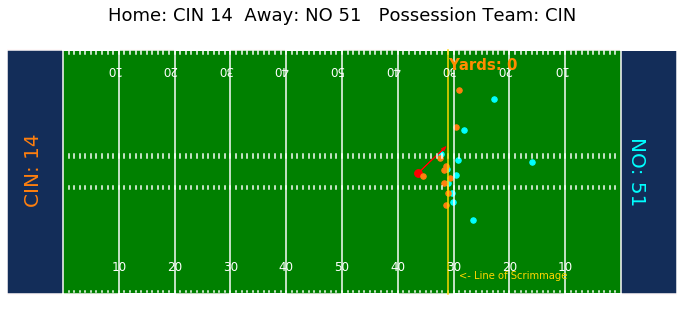

In [373]:
playid = list(set(data['playid']))[15]
los = line_of_scrimmage(playid)
print('los: ', los, 'yardline: ', data.loc[data['playid'] == playid]['yardline'].tolist()[0])
plot_play(playid)
plt.show()

# Multiple Scatter Plots

In [516]:
import os
# plot the different scatter plots 
def plots_for_gif(sec, playid):
    '''
    inputs: sec = number of seconds the play lasts (integer)
    playno = an integer between 0 and 31006
    
    
    plot the location of players in quarter second time intervals
    saves the pngs to convert to gif
    
    output: sec*4 scatter plots
    print statement of success - requires os package to be imported
    '''
    #playid = list(set(data['playid']))[playno]
    play = data.loc[data['playid'] == playid]
    los = line_of_scrimmage(playid)
    if play['playdirection'].tolist()[0] == 'left':
        play['dir'] = 180 + play['dir']
    if los > 60:
        if play['playdirection'].tolist()[0] == 'left':
            play['x_standard'] = play['x_standard'] + 2*abs(50-play['yardline'])
    else:
        if play['playdirection'].tolist()[0] == 'left':
            play['x_standard'] = play['x_standard'] - 2*abs(50-play['yardline'])
    # get a time estimate for play duration
    # time = dist/speed + 0.5 (half a second padding)
    #sec = round(play['yards'].tolist()[0]/play.loc[play['rusher'] == 1]['s'].tolist()[0] + 0.5,2)
    for i in np.arange(0, sec, 0.25):
        # set the field as the plotspace 
        
        fig, ax = plot_field(highlight_los = True,
                    highlight_los_number = los) 
        
        # empty lists for scatter plots
        x_list = []
        y_list = []
        color_list = []
        # play information
        hometeam = play['hometeamabbr'].tolist()[0]
        visitorteam = play['visitorteamabbr'].tolist()[0]
        homescore = play['homescorebeforeplay'].tolist()[0]
        visitorscore = play['visitorscorebeforeplay'].tolist()[0]
        # get offense and defense
        if play['possessionteam'].tolist()[0] == play['hometeamabbr'].tolist()[0]:
            offense = str(play['hometeamabbr'].tolist()[0])
            defense = str(play['visitorteamabbr'].tolist()[0])
        else:
            offense = str(play['visitorteamabbr'].tolist()[0])
            defense = str(play['hometeamabbr'].tolist()[0])
        for index, row in play.iterrows():
            # coordinates of player position
            x = row['x_standard']
            y = row['y_standard']
            # distance traveled = speed*time + acc/2*time^2
            d = row['s']*i + row['a']/2*i**2
            dx = d * math.cos(math.radians(row['dir']))
            dy = d * math.sin(math.radians(row['dir']))
            # keep players on the field
            if y + dy > 53.3:
                y_coord = 53
            elif y + dy < 0:
                y_coord = 0
            else:
                y_coord = y + dy
            if x + dx > 120:
                x_coord = 120
            elif x + dx < 0:
                x_coord = 0
            else:
                x_coord = x + dx
            x_list.append(x_coord)
            y_list.append(y_coord)
            # color the points
            # rusher = red
            if row['rusher'] == 1:
                color_list.append('red')
            # offense = orange
            elif row['offense'] == 1:
                color_list.append('orange')
            # defense = cyan
            else: 
                color_list.append('tab:blue')
            # print the yards gained at the top of the plot
            if los > 50:
                y_los = los
            else:
                y_los = los + 10
             
            yard_strip = patches.Rectangle((y_los, 52.3), # height of rectangle
                                      play['yards'].tolist()[0], # width of rectangle
                                      1, linewidth = 0.1,
                                      facecolor = 'darkorange')
            ax.add_patch(yard_strip)
            plt.text(y_los, 49, 
                    'Yards: {}'.format(play['yards'].tolist()[0]),
                    color = 'darkorange',
                    fontsize = 15,
                    weight = 'bold')
            #print('x: {}, y: {}, dx: {}, dy: {}'.format(x,y,dx,dy))
            plt.scatter(x = x_list,
                   y = y_list, 
                    color = color_list,  
                    s = 50)   
        plt.title('Home: {} {}   Visitor: {} {}   Offense: {}'.format(hometeam,\
                                                                 homescore,\
                                                                 visitorteam,\
                                                                 visitorscore,\
                                                                 offense),
                 fontsize = 20)
        # plot endzone teams
        plt.text(x = 3, y = 26, s = str(offense), 
                 rotation = 90, color = 'orange', 
                 size = 20, weight = 'bold')
        plt.text(x = 112, y = 26, s = str(defense), 
                 rotation = -90, color = 'tab:blue', 
                 size = 20, weight = 'bold')
        # save each plot as its own .png file
        filename = str(playid) + 'step' + str(i) + '.png'
        plt.savefig(filename, dpi = 96)
        plt.gca()
        #plt.close(fig)
    print('Success! {} png files saved in {}'.format(int(sec*4), os.getcwd()))


# Function to Save as a GIF

In [517]:
from PIL import Image
import glob

def save_gif(playno):
    frames = []
    # find all the pngs for the play number
    imgs = glob.glob(str(playno) + 'step*' + '.png')
    imgs.sort()
    for i in imgs:
        new_frame = Image.open(i)
        frames.append(new_frame)
    frames[0].save('Play' + str(playno) + '.gif', format = 'GIF',
                  append_images = frames[1:],
                  save_all = True,
                  duration = 300,
                  loop = 0)
    print('Great work! Your GIF has been saved in ', os.getcwd())

In [446]:
plots_for_gif(3, playid)

Success! 26 png files saved in /Users/jasonmaloney/Documents/GitHub/Rush-Yards


# Function for User Interaction

In [526]:
def user_graph():
    # get user input
    num = input('Please enter a number between 0 and 31006: ')
    # convert str to int
    try:
        play_no = int(num)
    except:
        return print('Sorry, that is not a number, please try again foolio!')
    # get the play id from data
    playid = list(set(data['playid']))[play_no]
    # check it is valid
    if (play_no)<0 or (play_no)>31006:
        return print('Close, but that play is not in our data. Try again sucka!')
    # check if user wants a GIF
    gif = input('Would you like to save this play as a GIF? Y/N: ')
    if (gif =='Y') or (gif == 'y'):
        print('Great choice!')
        plots_for_gif(2.75, playid)
        save_gif(playid)
    else:
        print('No worries, there is always next time!')
    # plot the play with rusher direction
    plot_play(playid)
    # get play info for random forest
    cols = list(trainX.columns)
    # get play info
    play_info = data.loc[data['playid'] == playid]
    # prediction
    y_pred = rf.predict(play_info[cols])
    # actual value (bin)
    y_true = data.loc[data['playid'] == playid]['yards_bin_int'].tolist()[0]
    # true value (exact)
    yards = data.loc[data['playid'] == playid]['yards'].tolist()[0]
    # get the bin keys from the value (from bin_int dictionary from above)
    for rng, bucket in bin_int.items():
        if bucket == y_pred[0]:
            pred = rng
        if bucket == y_true:
            true = rng
    # play result
    if (play_info['distance'].tolist()[0] <= play_info['yards'].tolist()[0]):
        if play_info['possessionteam'].tolist()[0] != play_info['fieldposition'].tolist()[0]:
            result = 'Touchdown!'
            new_dist = 'Extra Point Attempt'
        else:
            result = 'Firstdown'
            new_dist = 10
    else:
        result = str(play_info['down'].tolist()[0] + 1) + ' down'
        new_dist = play_info['distance'].tolist()[0] - play_info['yards'].tolist()[0]
    
    
    print('\nOffensive Formation: ', play_info['offenseformation'].tolist()[0])
    print('\nRusher: ', play_info.loc[play_info['rusher'] == 1]['displayname'].tolist()[0])
    print('\nNumber of Players in the Box: ', play_info['defendersinthebox'].tolist()[0])
    print('\nDefensive Personnel: ', play_info['defensepersonnel'].tolist()[0])
    print('\nDown: ', play_info['down'].tolist()[0], ' Distance: ', play_info['distance'].tolist()[0])
    print('\nYards Predicted: ', pred, ' Yards Gained: ', true, ' Exact Yards Gained: ', yards)
    print('\nResult of Play: ', result, ' Distance :', new_dist)   

# User Interaction
1. Press Shift+Enter to run the command below
2. Follow the prompts, press Enter after each prompt
3. Enjoy!

Please enter a number between 0 and 31006: 4357
Would you like to save this play as a GIF? Y/N: n
No worries, there is always next time!

Offensive Formation:  SINGLEBACK

Rusher:  Aaron Jones

Number of Players in the Box:  6.0

Defensive Personnel:  4 DL, 2 LB, 5 DB

Down:  1  Distance:  10

Yards Predicted:  0 to 3  Yards Gained:  8 to 10  Exact Yards Gained:  10

Result of Play:  Touchdown!  Distance : Extra Point Attempt


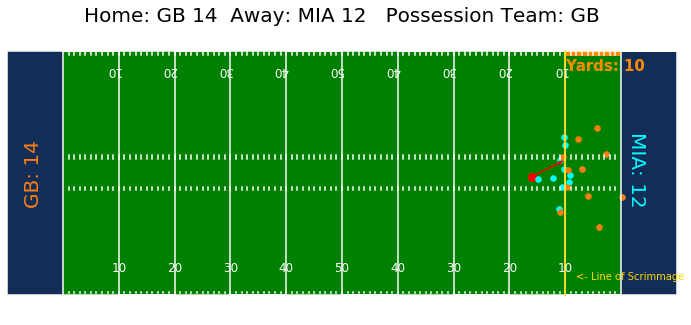

In [536]:
user_graph()